# 📊 Case Study 2: Statistical Enhancements for 90-Day Inhalation Toxicity Study

This notebook provides low-to-moderate cost enhancements to the original analysis of the 90-day inhalation toxicity study evaluating PG/VG with and without nicotine in rats. It includes:

- ANCOVA for adjusted comparisons
- Mixed-effects models for repeated measurements
- Effect size estimation (Cohen’s d)
- PCA for dimensionality reduction
- Sensitivity analysis
- Power analysis

The enhancements are aligned with regulatory expectations and aim to improve precision, interpretability, and reproducibility.


## 📁 Simulate Example Dataset

In [1]:

import pandas as pd
import numpy as np

np.random.seed(42)
groups = ["Sham", "Saline", "PGVG_Low", "PGVG_Med", "PGVG_High", "Nic_Low", "Nic_Med", "Nic_High"]
n_animals = 10

data = []
for group in groups:
    for i in range(n_animals):
        animal_id = f"{group}_{i}"
        baseline_weight = np.random.normal(250, 10)
        timepoints = [0, 30, 60, 90]
        for t in timepoints:
            weight = baseline_weight + np.random.normal(0.5*t, 3)
            lung_weight = np.random.normal(1.5 + 0.1*groups.index(group), 0.1)
            data.append([animal_id, group, t, baseline_weight, weight, lung_weight])

df = pd.DataFrame(data, columns=["animal_id", "group", "timepoint", "baseline_weight", "weight", "lung_weight"])
df.head()


,animal_id,group,timepoint,baseline_weight,weight,lung_weight
0,Sham_0,Sham,0,254.967142,254.552349,1.564769
1,Sham_0,Sham,30,254.967142,274.536231,1.476585
2,Sham_0,Sham,60,254.967142,284.264731,1.657921
3,Sham_0,Sham,90,254.967142,302.269446,1.453053
4,Sham_1,Sham,0,255.425600,254.035347,1.453427


## 📐 ANCOVA: Adjusting Lung Weight for Baseline Body Weight


In this study, different exposure groups might begin with slightly different body weights. Using ANCOVA allows us to compare lung weights between groups while adjusting for these baseline differences, improving the precision of our inference.


In [3]:

import statsmodels.formula.api as smf

# Use final timepoint only for ANCOVA
ancova_data = df[df["timepoint"] == 90]
model = smf.ols("lung_weight ~ C(group) + baseline_weight", data=ancova_data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            lung_weight   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     55.72
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           1.43e-27
Time:                        23:57:36   Log-Likelihood:                 79.975
No. Observations:                  80   AIC:                            -142.0
Df Residuals:                      71   BIC:                            -120.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.34

## 🔄 Mixed Effects Model: Longitudinal Weight Changes


To properly model repeated measurements of weight over time for each rat, a linear mixed-effects model accounts for both group effects and within-animal correlation. This is critical in toxicology studies where weight gain or loss over time is monitored.


In [4]:

import statsmodels.api as sm

md = smf.mixedlm("weight ~ C(group) * timepoint", df, groups=df["animal_id"])
mdf = md.fit()
print(mdf.summary())


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        weight   
No. Observations:         320            Method:                    REML     
No. Groups:               80             Scale:                     9.2292   
Min. group size:          4              Log-Likelihood:            -953.3288
Max. group size:          4              Converged:                 Yes      
Mean group size:          4.0                                                
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       245.090    2.859 85.718 0.000 239.486 250.694
C(group)[T.Nic_Low]              -0.326    4.044 -0.081 0.936  -8.251   7.599
C(group)[T.Nic_Med]               8.235    4.044  2.036 0.042   0.309  16.160
C(grou

C:\Users\keebs\Anaconda\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


## 📏 Cohen’s d: Effect Size Between Sham and PGVG High


Effect size provides an estimate of the magnitude of difference between two groups. In regulatory toxicology, it's important to know not just whether a change is statistically significant, but whether it is biologically meaningful.


In [5]:

control = ancova_data[ancova_data["group"] == "Sham"]["lung_weight"]
high_dose = ancova_data[ancova_data["group"] == "PGVG_High"]["lung_weight"]
cohen_d = (high_dose.mean() - control.mean()) / np.sqrt((control.var() + high_dose.var()) / 2)
print(f"Cohen's d: {cohen_d:.3f}")


Cohen's d: 4.289


## 🔍 PCA: Organ Weight Dimensionality Reduction


Principal Component Analysis helps visualize clustering and identify group separation in multivariate data. This is helpful when analyzing organ weights or omics data to identify patterns related to exposure.


C:\Users\keebs\AppData\Local\Temp\ipykernel_27092\2472918612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancova_data["PC1"] = pca_out[:, 0]
C:\Users\keebs\AppData\Local\Temp\ipykernel_27092\2472918612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancova_data["PC2"] = pca_out[:, 1]


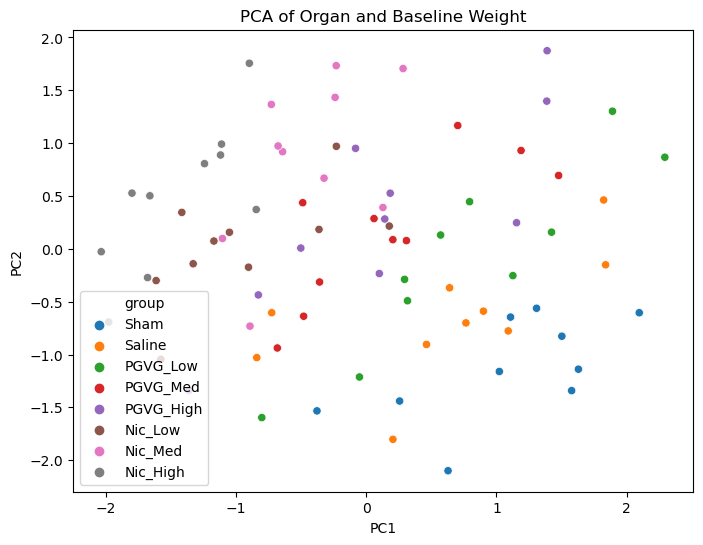

In [6]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca_data = ancova_data[["lung_weight", "baseline_weight"]]
pca_std = (pca_data - pca_data.mean()) / pca_data.std()
pca = PCA(n_components=2)
pca_out = pca.fit_transform(pca_std)

ancova_data["PC1"] = pca_out[:, 0]
ancova_data["PC2"] = pca_out[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ancova_data, x="PC1", y="PC2", hue="group")
plt.title("PCA of Organ and Baseline Weight")
plt.show()


## 🧪 Sensitivity Analysis: Excluding PGVG_High Group


Sensitivity analysis checks the robustness of our findings. Here, we re-run the ANCOVA excluding the high dose group to see how much it influences the results.


In [7]:

sens_data = ancova_data[ancova_data["group"] != "PGVG_High"]
sens_model = smf.ols("lung_weight ~ C(group) + baseline_weight", data=sens_data).fit()
print(sens_model.summary())


                            OLS Regression Results                            
Dep. Variable:            lung_weight   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     62.77
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           9.67e-26
Time:                        23:58:19   Log-Likelihood:                 69.629
No. Observations:                  70   AIC:                            -123.3
Df Residuals:                      62   BIC:                            -105.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.3846 

## ⚡ Power Analysis: Sample Size Planning


Power analysis is used to determine whether the sample size is sufficient to detect a biologically relevant effect. This is especially important in transcriptomics or when null results are observed.


In [8]:

from statsmodels.stats.power import TTestIndPower

# Estimate power for effect size observed between Sham and PGVG_High
analysis = TTestIndPower()
power = analysis.power(effect_size=cohen_d, nobs1=10, alpha=0.05, ratio=1.0)
print(f"Estimated power: {power:.2f}")


Estimated power: 1.00
